# Brief Métier : Prédiction de Churn Clients avec le Deep Learning

__________________________________________________________________________________________________________________________________________________

## 1. Contexte professionnel
Vous êtes **Data Scientists** dans une ESN (Entreprise de Services Numériques) qui accompagne les opérateurs télécoms dans la réduction de la perte d’abonnés.
Votre nouveau client, **TelcoNova**, souhaite anticiper les départs de ses clients (churn) afin d’orienter ses campagnes de rétention.

Il met à votre disposition un extrait anonymisé de sa base CRM (le jeu Telco Customer Churn, déjà pré-nettoyé en grande partie) et vous laisse **3 jours** pour livrer un premier prototype de modèle de prédiction exploitable en production.

TelcoNova exige un livrable reproductible et facilement intégrable par ses équipes MLOps ; vous travaillerez **en binôme**, en suivant les bonnes pratiques Git / GitHub.


__________________________________________________________________________________________________________________________________________________

## 2. Votre mission

1. **Explorer & préparer les données** :

    + audit qualité, gestion des valeurs manquantes, etc.


In [1]:
import pandas as pd
import numpy as np

dataframe = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
for index, column in enumerate ( dataframe.columns) :
    print(f"{index}: {column}, ", end='')
    num_values = dataframe[column].nunique()
    is_numeric = pd.api.types.is_numeric_dtype(dataframe[column])
    numeric_type = str(dataframe[column].dtype)
    print(f"{num_values}{(' '+numeric_type) if is_numeric else ''} values", end='')
    if num_values < 10 :
        print(f": " + ', '.join(str(x) for x in dataframe[column].unique())) 
    else :
        print(f".") 



0: customerID, 7043 values.
1: gender, 2 values: Female, Male
2: SeniorCitizen, 2 int64 values: 0, 1
3: Partner, 2 values: Yes, No
4: Dependents, 2 values: No, Yes
5: tenure, 73 int64 values.
6: PhoneService, 2 values: No, Yes
7: MultipleLines, 3 values: No phone service, No, Yes
8: InternetService, 3 values: DSL, Fiber optic, No
9: OnlineSecurity, 3 values: No, Yes, No internet service
10: OnlineBackup, 3 values: Yes, No, No internet service
11: DeviceProtection, 3 values: No, Yes, No internet service
12: TechSupport, 3 values: No, Yes, No internet service
13: StreamingTV, 3 values: No, Yes, No internet service
14: StreamingMovies, 3 values: No, Yes, No internet service
15: Contract, 3 values: Month-to-month, One year, Two year
16: PaperlessBilling, 2 values: Yes, No
17: PaymentMethod, 4 values: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
18: MonthlyCharges, 1585 float64 values.
19: TotalCharges, 6531 values.
20: Churn, 2 values: No, Yes


In [2]:
# exploration des colonnes à plus de 10 valeurs

def check_float(dataframe : pd.DataFrame, columnname : str) :
    print(f"{columnname}:")
    numericount =0
    notnumericount =0
    for value in dataframe[columnname].unique() :
        try :
            numeric_value = float(value)
            numericount+=1
        except :
            notnumericount+=1

    print(f"{numericount} numeric values, {notnumericount} other values")
    print()

# 0: customerID, 7043 values => drop column
# 5: tenure, 73 int64 values => int64
# 18: MonthlyCharges, 1585 float64 values => float64
check_float(dataframe, 'MonthlyCharges')

# 19: TotalCharges, 6531 values : Exploration
check_float(dataframe, 'TotalCharges')


MonthlyCharges:
1585 numeric values, 0 other values

TotalCharges:
6530 numeric values, 1 other values



In [3]:
import sys
import os

# Ajouter le chemin absolu du dossier src au sys.path
sys.path.append(os.path.abspath('../src'))
from pipeline_functions import exclude_spaces

print(f"before : {dataframe['TotalCharges'].dtype}")

dataframe2 = exclude_spaces('TotalCharges')(dataframe)

print(f"after : {dataframe2['TotalCharges'].dtype}")



2025-05-22 10:31:46.952140: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 10:31:46.955121: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 10:31:46.963978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747902706.978821   18886 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747902706.983013   18886 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747902706.993852   18886 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

before : object
after : float64


  + encodage des variables / normalisation / standardisation des variables


In [4]:
from pipeline_functions import create_preprocessor

preprocessor = create_preprocessor()
preprocessor


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('functiontransformer-1',
                                                  FunctionTransformer(func=<function create_preprocessor.<locals>.<lambda> at 0x729017be3a60>),
                                                  ['gender']),
                                                 ('binarizer', Binarizer(),
                                                  ['SeniorCitizen']),
                                                 ('functiontransformer-2',
                                                  FunctionTransformer(func=<function create_preprocessor.<locals...
                                                  FunctionTransformer(func=<function create_preprocessor.<locals>.<lambda> at 0x728f81fca020>),
                                                  ['PaperlessBilling']),
                                                 ('onehotencoder-10',
                                                  OneHotEncoder(),
                                                  ['PaymentMethod']),
                                                 ('standardscaler-2',
                                                  StandardScaler(),
                                                  ['MonthlyCharges']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function exclude_spaces.<locals>.transform at 0x728f81fca840>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['TotalCharges'])]))])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split


# modele de référence 
sklearn_model = LogisticRegression()
sklearn_model.set_params()


complete_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", sklearn_model)]
)

y = [1 if x == 'Yes' else 0 for x in dataframe['Churn']]
X = dataframe.drop(columns=['customerID','Churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

complete_pipeline.fit(X_train, y_train)

# Prédiction
y_pred = complete_pipeline.predict(X_test)
y_proba = complete_pipeline.predict_proba(X_test)[:, 1]  # pour le ROC AUC

# Évaluation
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("model score: %.3f" % complete_pipeline.score(X_test, y_test))
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"ROC AUC  : {auc:.4f}")



model score: 0.822
Accuracy : 0.8219
Precision: 0.6871
ROC AUC  : 0.8622




2. **Élaborer un pipeline d’entraînement** sous **TensorFlow Keras ou PyTorch** (au choix) :

  + architecture MLP pensée pour la tabulaire : ≥ 2 couches cachées,

  + fonction de perte adaptée à une classification binaire,

  + gestion éventuelle du déséquilibre de classes.


In [10]:
# add comment

from pipeline_functions import build_nn_model
import tensorflow as tf

y = [1 if x == 'Yes' else 0 for x in dataframe['Churn']]
X = dataframe.drop(columns=['customerID','Churn'])

X = preprocessor.fit_transform(X)

X_train_0, X_test, y_train_0, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )
X_train, X_val, y_train, y_val = train_test_split( X_train_0, y_train_0, test_size=0.2, random_state=42, stratify=y_train_0 )

input_shape = (X_train.shape[1],)

deepl_classifier : tf.keras.Model = build_nn_model(input_shape)

print(deepl_classifier)
deepl_classifier.summary()

<Sequential name=sequential_1, built=True>


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,249 (20.50 KB)

 Trainable params: 5,249 (20.50 KB)

 Non-trainable params: 0 (0.00 B)

  + callbacks (EarlyStopping, ModelCheckpoint, TensorBoard ou équivalent) pour suivre l’entraînement,


In [7]:
X_train = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val = X_val.toarray() if hasattr(X_val, "toarray") else X_val

y_train = np.array(y_train)
y_val = np.array(y_val)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # surveille la perte de validation
    patience=3,            # tolère 3 époques sans amélioration
    restore_best_weights=True
)

history = deepl_classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=30,
    verbose=1,
    callbacks=[early_stop]
)



Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5540 - loss: 0.6935 - precision: 0.2977 - roc_auc: 0.5456 - val_accuracy: 0.7347 - val_loss: 0.5444 - val_precision: 0.0000e+00 - val_roc_auc: 0.8328
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7438 - loss: 0.5143 - precision: 0.2867 - roc_auc: 0.8112 - val_accuracy: 0.8012 - val_loss: 0.4462 - val_precision: 0.7168 - val_roc_auc: 0.8419
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.4358 - precision: 0.6469 - roc_auc: 0.8369 - val_accuracy: 0.8083 - val_loss: 0.4291 - val_precision: 0.6694 - val_roc_auc: 0.8442
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8020 - loss: 0.4380 - precision: 0.6595 - roc_auc: 0.8364 - val_accuracy: 0.8163 - val_loss: 0.4276 - val_precision: 0.7000 - val_roc_auc: 0.8456
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4245 - precision: 0.6443 - roc_auc: 0.8417 - val_accuracy: 0.8

  + suivi des métriques : ROC-AUC, F1-score, Recall sur la classe Churn = Yes.


In [8]:
#test_loss, test_acc, test_pre, test_rec, test_auc, test_f1s = deepl_classifier.evaluate(X_val, y_val)
metrics = deepl_classifier.evaluate(X_val,y_val)
test_loss, test_acc, test_pre, test_auc = metrics
print(f"Loss      : {test_loss:.4f}")
print(f"Accuracy  : {test_acc:.4f}")
print(f"Precision : {test_pre:.4f}")
# print(f"Recall    : {test_rec:.4f}")
print(f"ROC-AUC   : {test_auc:.4f}")
#print(f"F1-score  : {test_f1s:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8251 - loss: 0.4012 - precision: 0.7088 - roc_auc: 0.8584 
Loss      : 0.4160
Accuracy  : 0.8146
Precision : 0.6940
ROC-AUC   : 0.8460


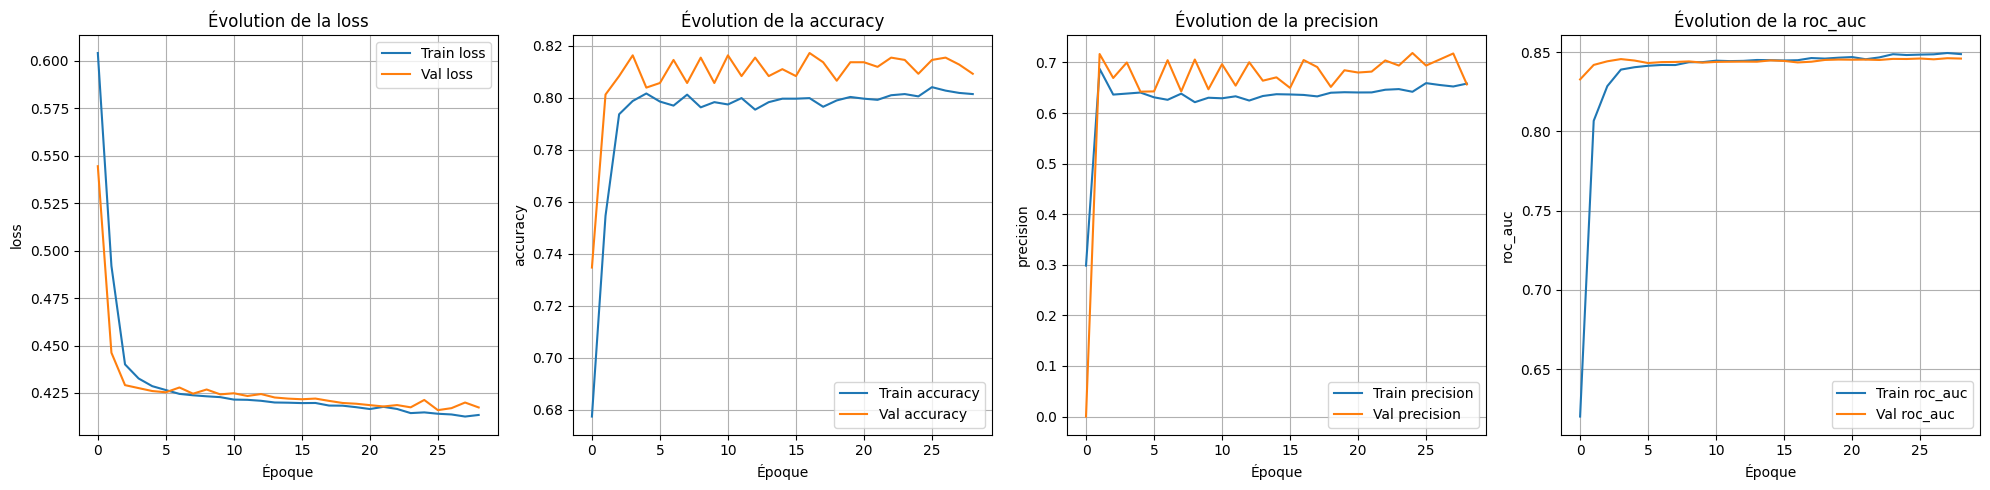

In [9]:
import matplotlib.pyplot as plt

def plot_history(ax, title:str, history, validation=True):
    ax.plot(history.history[title], label=f"Train {title}")

    val_title = "val_"+title
    if validation and val_title in history.history:
        ax.plot(history.history[val_title], label=f"Val {title}")
        
    ax.set_title(f"Évolution de la {title}")
    ax.set_xlabel('Époque')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid()

# Créer la figure et les axes (4 plots côte à côte)
fig1, axs = plt.subplots(1, 4, figsize=(20, 5))

plot_history(axs[0], "loss", history)
plot_history(axs[1], "accuracy", history)
plot_history(axs[2], "precision",history)
plot_history(axs[3], "roc_auc", history)

plt.tight_layout()
plt.show()
    




3. Évaluer, comparer, justifier :

  + fixer un **baseline** simple (régression logistique ou arbre de décision) pour mesurer le gain du réseau,

  + analyser les courbes d’apprentissage, la matrice de confusion, le ROC, les distributions des scores,

  + expliquer (au moins qualitativement) les variables les plus influentes.


4. Exporter le modèle + artefacts :

  + binaire du modèle (<span style="color: lightgreen;"><b>SavedModel</b></span> ↔ TensorFlow / fichier <span style="color: lightgreen;"><b>.pt</b></span> ↔ PyTorch),

  + scaler / encoder,

  + script ou notebook d’inférence qui charge les artefacts et prédit le churn sur de nouvelles données.


__________________________________________________________________________________________________________________________________________________

## 3. Fonctionnalités obligatoires (MVP)


<table style="width:75%">
  <tr>
    <th>Bloc</th>
    <th>Exigences clés</th>
  </tr>
  <tr>
    <th>Data Prep</th>
    <td>
        <ul>
            <li>Nettoyage & typage correct de <b>toutes</b> les colonnes</li>
            <li>Encodage systématique des catégorielles</li>
            <li>Split train / val / test (stratifié)</li>
        </ul>
    </td>
  </tr>
  <tr>
    <th>Modélisation</th>
    <td>
        <ul>
            <li>MLP implémenté <b>from scratch</b> sous TF /Keras <b>ou</b> PyTorch (pas d’API AutoML)</li>
            <li>Backprop + optimiseur (Adam ou SGD)</li>
            <li>Gestion du déséquilibre (pondération ou autre)</li>
        </ul>
    </td>
  </tr>
  <tr>
    <th>Suivi & répétabilité</th>
    <td>
      <ul>
        <li>TensorBoard ou PyTorch Lightning logger </li>
        <li>Seeds fixés + README détaillant la reproduction</li>
        <li>ModelCheckpoint pour restaurer le meilleur modèle</li>
      </ul>
    </td>
  </tr>
  <tr>
    <th>Évaluation</th>
    <td>
      <ul>
        <li>ROC-AUC ≥ 0 .80 <b>OU</b> F1 ≥ 0 .60</li>
        <li>Rapport comparant le réseau au baseline</li>
      </ul>
    </td>
  </tr>
  <tr>
    <th>Collaboration Git</th>
    <td>
      <ul>
        <li>1 branch = 1 feature</li>
        <li> Pull request systématique avec description</li>
      </ul> 
    </td>
  </tr>
</table>





__________________________________________________________________________________________________________________________________________________

## 4. Détails techniques & considérations
  + **Imbalance** : la classe Churn = Yes ≈ 26 %.

  + **Pré-processing dans le même pipeline** que l’inférence (pas de données “fuites” entre train et test).

  + **Hyperparamètres** : batch_size, learning_rate, nb_neurones par couche ; explorez‐les rapidement (Random Search / KerasTuner / Ray Tune) mais documentez votre stratégie.

  + **Éthique & RGPD** : aucune donnée personnellement identifiable ne doit sortir du cadre du projet.


__________________________________________________________________________________________________________________________________________________

## 5. Ressources utiles

  + **Docs officielles** :
 
    + TensorFlow /Keras : https://www.tensorflow.org/api_docs
    + PyTorch : https://pytorch.org/docs/
    + scikit-learn preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html

 + **Outils** :

    + KerasTuner, Optuna (hyper-tuning)
    + Imbalanced-learn (rééchantillonnage)

  + **Cours/vidéos** :

    + [DeepLearning.AI TensorFlow Developer (Coursera) – chapitres 2 & 3](http://DeepLearning.AI)
    + [PyTorch Lightning Crash Course (YouTube)](https://www.youtube.com/watch?v=OIenNRt2bjg)


__________________________________________________________________________________________________________________________________________________

## 6. Livrables
  + Code source python propre et documenté

  + ROC-AUC ≥ 0 .80 ou F1 ≥ 0 .60

  + README clair, pas de données personnelles commitées

  + Présentation prête (10 min max et tous les membres du groupes doivent parler)


____________________________________________________________________________________________________________________________

  + Groupe pour le brief :
    
    G1 = Khadija A.	+ Wael	

    G2 = Victor	+ Maxime + Antoine

    G3 = Ludivine + Dorothée	

    G4 = Malek + Nicolas G	

    G6 = Hacène + Elliandy	

    G7 = Raouf + Léo	

    G8 = Samuel	+ Michael	

    G9 = Sami +	Gauthier	

    G10 = Nicolas C + David	
   

